## Single Index Quantile Regression


Author: @Suoer Xu （Supervised by Prof. J. Zhang)

August 18th, 2019

This is a tutorial on how to use the Single Index Quantile Regression model package. The packages almost identically replicates the profile optimization discussed in Ma and He (2016). See the paper as
> https://pdfs.semanticscholar.org/9324/e31866435d446f147320f80acde682e8e614.pdf

Environment: Python 3

Package requirements: Numpy 1.16.3, Pandas 0.22.0, Scipy 1.3.1, Matplotlib 3.1.1.

### 1. Generate B-spline

According to Ma and He (2016, p4) and de Boor (2001), the nonparametric single index function $G_{\tau}(\cdot)$ can be approximated well
by a spline function such that $G_{\tau}(\cdot) \approx B(\cdot)^T\theta_{\tau} $, w.h. $B(\cdot)$ is the basis splines with respect to a given degree, smoothness, and domain partition. 

**Part I** provides a python code to generate the B-splines for any given interval and knots.The construction of B-Splines follows the Cox-de Boor recursion formula. See the description as
> https://en.wikipedia.org/wiki/B-spline 

\begin{align}
B_{i,1}(x) &= \left\{
\begin{array}{rl}
1 & \text{if } t_i \le x < t_{i+1} \\
0 & \text{if otherwise}.
\end{array} \right. \\
B_{i,k+1}(x) &= \dfrac{x-t_i}{t_{i+k}-t_i}B_{i,k}(x)+\dfrac{t_{i+k+1}-x}{t_{i+k+1}-t_{i+1}}B_{i+1,k}(x)
\end{align}

The derivatives which might be used latter in the sensitivity analysis can be easily put in

\begin{align}
B'_{i,k+1}(x) = \dfrac{1}{t_{i+k}-t_i}B_{i,k}(x)+\dfrac{x-t_i}{t_{i+k}-t_i}B'_{i,k}(x)+\dfrac{-1}{t_{i+k+1}-t_{i+1}}B_{i+1,k}(x)+\dfrac{t_{i+k+1}-x}{t_{i+k+1}-t_{i+1}}B'_{i+1,k}(x)
\end{align}

In [1]:
import numpy as np; import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint, BFGS

In [2]:
def indicator(x,a,b,right_close=False):
    if not right_close:
        if (x >= a) & (x < b):
            return 1
        else:
            return 0
    else:
        if (x >= a) & (x <= b):
            return 1
        else:
            return 0
def I(a,b,right_close=False):
    '''
    return indicator function for a <= x < (or <=) b
    '''
    def inter(x):
        return indicator(x,a,b,right_close)
    return inter

def add(I1,I2):
    '''
    define the addition
    '''
    def inter(x):
        return I1(x) + I2(x)
    return inter

def mult(I1,I2):
    '''
    define the multiplication
    '''
    def inter(x):
        return I1(x)*I2(x)
    return inter

def scalar(I,alpha):
    '''
    define the scalar multiplication
    '''
    def inter(x):
        return alpha*I(x)
    return inter

def f(x, t_1, t_2, x_large = True):
    if t_1 != t_2:
        if x_large:
            return (x - t_1)/(t_2 - t_1)
        else:
            return (t_2 - x)/(t_2 - t_1)
    else:
        return 0

def recur(t_1, t_2, x_large = True):
    '''
    return the recursion polynomial in the Cox-de Boor's algorithm
    '''
    def inter(x):
        return f(x, t_1, t_2, x_large)
    return inter

In [3]:
def partition(a,b,N):
    '''
    interval [a,b] is evenly partitioned into a = t_0 < t_1 < ... < t_N < b = t_N+1
    return the knots [t_0, t_1, ..., t_N+1]
    '''
    h = (b - a)/(N + 1)
    return [a + i*h for i in range(0,N+2)]

def extend(t, p):
    '''
    extend the original t of length N+1 into a dictionary of length N+1+2p, convinient for de Boor algorithm
    p is the final degree of the polynomials, i.e., p = m - 1 where m is the order of B-splines
    '''
    dic = {}
    N = len(t) - 1
    for i in range(p):
        dic[i-p] = t[0]
    for i in range(N+1):
        dic[i] = t[i]
    for i in range(p):
        dic[N+i+1] = t[N]
    return dic

In [4]:
def deBoor(a, b, m, N, deri = False):
    '''
    a, b : the infimum and supremum , or minimum and maximum, of the scalar product <X, \beta>
    m    : the order of B-spline (>= 2)
    N    : the number of partition, i.e., [t0(=a), t1], [t1, t2], ... , [tN, tN+1(=b)]
    deri : when True, return the derivatives. Default is False
    '''
    # the choice of N follow the implementation in Ma and He (2016, p9)
    p = m - 1
    t = partition(a,b,N)
    t = extend(t,p)
    
    if not deri:
        B_k_1 = {}
        for i in range(-p, N + p + 1) :
            B_k_1[i] = I(t[i],t[i+1])
    
        for k in range(1, p + 1):
            B_k_0 = B_k_1
            B_k_1 = {}
            for i in range(-p, N + p + 1 - k):
                recursion0 = mult( B_k_0[i] , recur(t[i], t[i+k], True) )
                recursion1 = mult( B_k_0[i+1] , recur(t[i+1], t[i+k+1], False) )
                B_k_1[i] = add(recursion0, recursion1)
        return B_k_1
    else:
        B_k_1 = {}
        b_k_1 = {}
        for i in range(-p, N + p + 1) :
            B_k_1[i] = I(t[i],t[i+1])
            b_k_1[i] = I(0.,0.)
        
        for k in range(1, p + 1):
            B_k_0 = B_k_1
            b_k_0 = b_k_1
            B_k_1 = {}
            b_k_1 = {}
            for i in range(-p, N + p + 1 - k):
                recursion0 = mult( B_k_0[i] , recur(t[i], t[i+k], True) )
                recursion1 = mult( B_k_0[i+1] , recur(t[i+1], t[i+k+1], False) )
                B_k_1[i] = add(recursion0, recursion1)
                
                deri1 = mult( b_k_0[i] , recur(t[i], t[i+k], True) )
                deri2 = mult( b_k_0[i+1] , recur(t[i+1], t[i+k+1], False) )
                deri3 = scalar( B_k_0[i] , recur(t[i], t[i+k], True)(t[i]+1) )
                deri4 = scalar( B_k_0[i+1] , recur(t[i+1], t[i+k+1], False)(t[i+k+1]+1) )
                b_k_1[i] = add( add(deri1,deri2) , add(deri3,deri4) )
        return B_k_1, b_k_1

In [5]:
# an example is provided
a, b, m, N = 0, 12, 4, 3

In [6]:
B_spline, b_deri = deBoor(a, b, m, N, True)
B_spline

{-3: <function __main__.add.<locals>.inter(x)>,
 -2: <function __main__.add.<locals>.inter(x)>,
 -1: <function __main__.add.<locals>.inter(x)>,
 0: <function __main__.add.<locals>.inter(x)>,
 1: <function __main__.add.<locals>.inter(x)>,
 2: <function __main__.add.<locals>.inter(x)>,
 3: <function __main__.add.<locals>.inter(x)>}

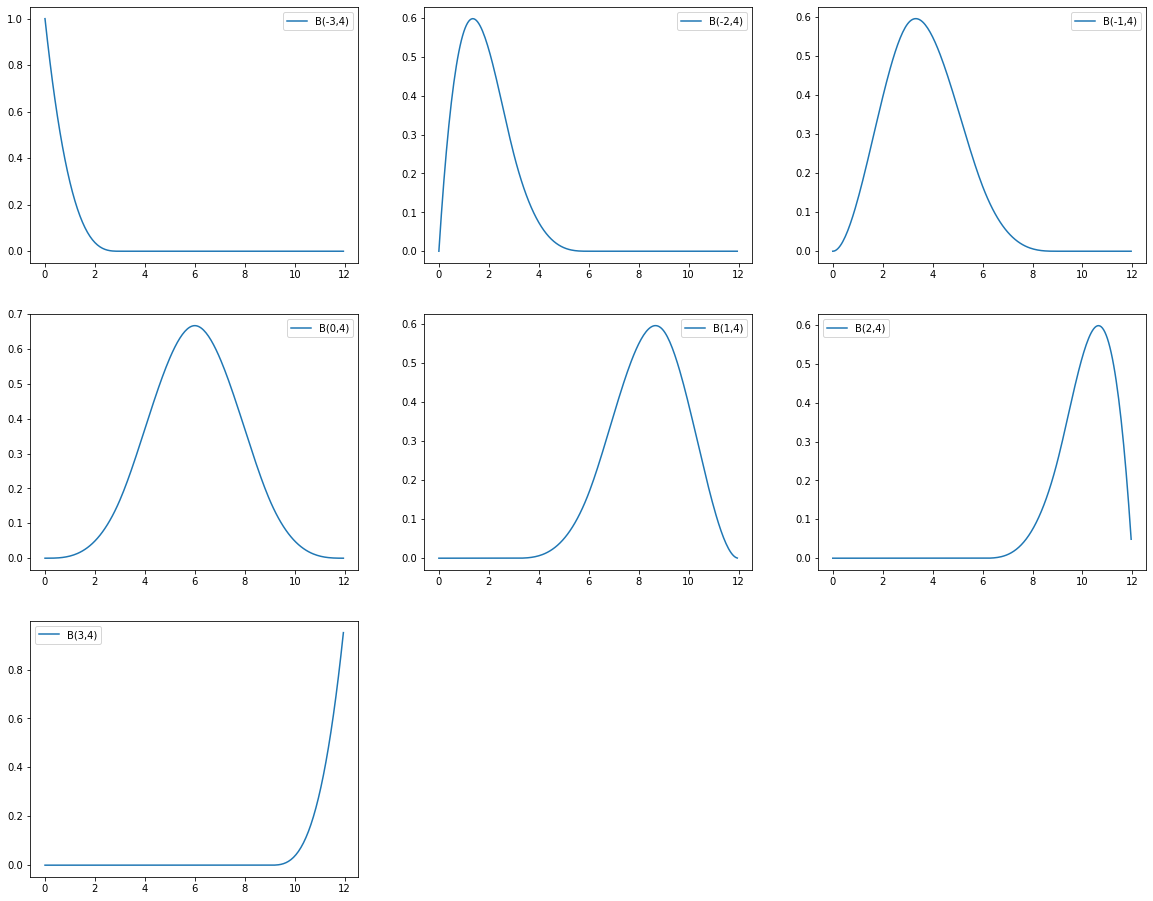

In [7]:
plt.figure(figsize=(20,16))
for i in list(B_spline.keys()):
    plt.subplot(3,3,i - list(B_spline.keys())[0] + 1)
    X = np.arange(0,12,0.05)
    Y = [B_spline[i](j) for j in X]
    l = 'B(' + str(i) + ',' + str(m) + ')'
    plt.plot(X,Y,label=l)
    plt.legend()
plt.show()

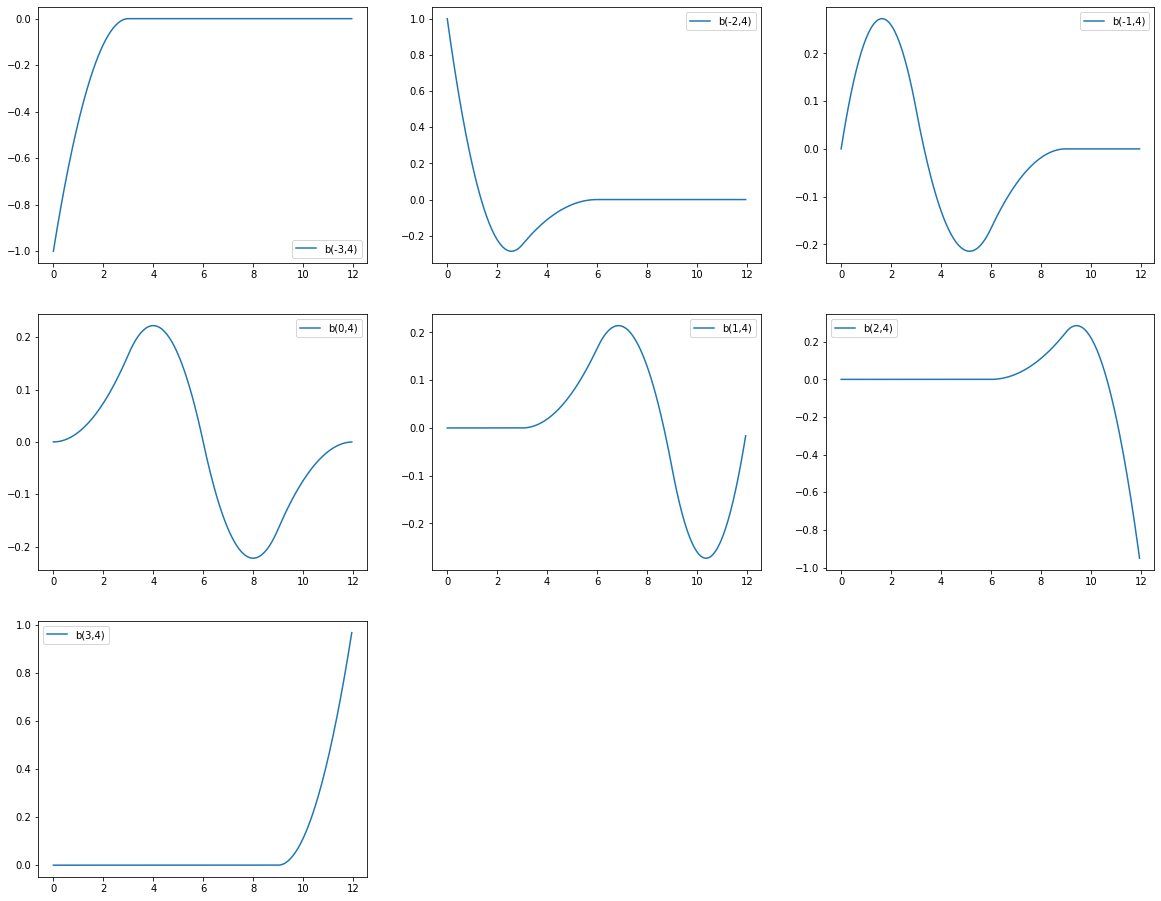

In [10]:
plt.figure(figsize=(20,16))
for i in list(b_deri.keys()):
    plt.subplot(3,3,i - list(b_deri.keys())[0] + 1)
    X = np.arange(0,12,0.05)
    Y = [b_deri[i](j) for j in X]
    l = 'b(' + str(i) + ',' + str(m) + ')'
    plt.plot(X,Y,label=l)
    plt.legend()
plt.show()

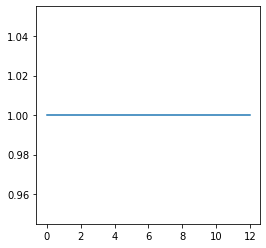

In [13]:
# sanity check: the sum of B-splines should be 1 over the domain

ss = lambda x : 0
for i in list(B_spline.keys()):
    ss = add(ss,B_spline[i])
x = np.arange(0,12,0.05)
y = [ss(j) for j in x]
plt.figure(figsize=(4,4))
plt.plot(x,y)
plt.show()

### 2. Determine the infimum and supremum of $x^T\beta$

Y: 
+ the log return of 000001.SZ

X: 
+ the log return of other main commercial banks (listed before 2011) 
+ 000001.SZ specific characteristics 
+ macro state variables

In [ ]:
data1 = pd.read_csv('results/log_return.csv').dropna()
data2 = pd.read_csv('results/000001_specific.csv').dropna()
data3 = pd.read_csv('results/macro_state.csv').dropna()

In [ ]:
X = pd.concat([data1[data1.columns[2:]], data2[data2.columns[1:]], data3[data3.columns[1:]]], axis = 1)
Y = data1[data1.columns[1]]
X = np.array(X)
Y = np.array(Y)

In [ ]:
# sanity check
print(X.shape)
print(Y.shape)

In [ ]:
def u(x):
    def inter(beta):
        return np.dot(x,beta)/np.sqrt((beta**2).sum())
    return inter
def v(x):
    def inter(beta):
        return -1. * np.dot(x,beta)/np.sqrt((beta**2).sum())
    return inter

def min_max(x, min_ = True):
    d = len(x)
    beta0 = np.ones(d)
    
    # define the linear constraint beta_0 > 0
    ub = np.ones(d)*np.inf
    lb = - np.ones(d)*np.inf
    lb[0] = 0.
    bou = Bounds(lb, ub)
    
    if min_:
        res = minimize(u(x), beta0, method='L-BFGS-B',bounds = bou)
    else:
        res = minimize(v(x), beta0, method='L-BFGS-B',bounds = bou)
    return u(x)(res.x)
    
def inf_sup(X):
    n = X.shape[0]
    d = X.shape[1]
    inf, sup = [], []
    for i in range(n):
        inf = inf + [min_max(X[i], min_ = True)]
        sup = sup + [min_max(X[i], min_ = False)]
    return np.array(inf).min(),np.array(sup).max()

In [ ]:
a, b = inf_sup(X)

In [ ]:
print(a,b)

### 3. Define the loss function

In [ ]:
n = X.shape[0]
m = 4
N = round(n**(1/(2*m+1))) + 1
dB = deBoor(a, b, m, N)
B = [i for i in dB.values()]
tau = 0.95

In [ ]:
def linear(B,theta):
    '''
    B     : list of basis splines, dimension J = N + m
    theta : control points of basis splines, (J,) array
    '''
    J = len(theta)
    lin = scalar(B[0],theta[0])
    for i in range(1,J):
        lin = add(lin, scalar(B[i],theta[i]))
    return lin

def rho(s,tau):
    '''
    define the pinball loss
    '''
    if s >= 0:
        return tau*s 
    if s < 0:
        return (tau - 1)*s

def SIQ_loss(X,Y,beta,B,theta,tau):
    '''
    X     : sample input, (n, d) array
    Y     : sample output, (n,) array
    beta  : index, (d,) array
    B     : list of basis splines, dimension J = N + m
    theta : control points of basis splines, (J,) array
    tau   : quantile to be estimated
    '''
    n = X.shape[0]
    
    L = 0.
    for i in range(n):
        lin = linear(B, theta)
        s = Y[i] - lin( u(X[i])(beta) )
        L += rho(s,tau)
    return L/n

### 4. Optimization for nonparametric function $G(\cdot)$ given index $\beta$

In [ ]:
def loss_on_theta(X,Y,beta,B,tau):
    def inter(theta):
        return SIQ_loss(X,Y,beta,B,theta,tau)
    return inter

def theta_on_others(X,Y,beta,B,tau,theta0):
    J = len(B)
    res = minimize(loss_on_theta(X,Y,beta,B,tau), theta0, method='BFGS')
    return res.x

### 5. Optimization for Index $\beta$

In [ ]:
def loss_on_beta_(X,Y,B,theta,tau):
    def inter(beta):
        return SIQ_loss(X,Y,beta,B,theta,tau)
    return inter

def beta_on_others_(X,Y,B,theta,tau,beta0):
    d = X.shape[1]
    
    # define the linear constraint beta_0 > 0
    ub = np.ones(d)*np.inf
    lb = - np.ones(d)*np.inf
    lb[0] = 0.
    bou = Bounds(lb, ub)
    
    res = minimize(loss_on_beta_(X,Y,B,theta,tau), beta0, method='L-BFGS-B',bounds = bou)

    return res.x

### 4*. Optimization for both $\beta$ and $G(\cdot)$

### 5. Optimization for nonparametric function $G(\cdot)$

\begin{align}
BIC(N_n) = \log\{\text{Loss}\} + \dfrac{\log n}{2n}(N_n+m)
\end{align}

In [ ]:
record = {}
for N_n in range(2,2*N):
    dB_n = deBoor(a, b, m, N_n)
    B_n = [i for i in dB_n.values()]
    theta_n = theta_on_others(X,Y,beta,B_n,tau)
    BIC_n = np.log(SIQ_loss(X,Y,beta,B_n,theta_n,tau)) + np.log(n)/(2*n)*(N_n+m)
    record[N_n] = [theta, BIC_n]

In [ ]:
record_df = DataFrame(record, index=['theta','BIC']).T
record_df